# Preamble and Objective

One of my favourite pastimes is following basketball, particularly through the subreddit r/nba. The users here are particularly well versed at making funny/snarky references to recent controversies surrounding what nba athletes have said/done. This type of wit is well reflected in the types of posts that are made, especially with the titles.

For example, the past two months has seen a surge in post titles either disparaging or supporting one of three MVP frontrunner candidates: Joel Embiid, Nikola Jokic and Giannis Antetokounmpo. It's very clear when looking at popular post titles whether the objective is to make a case for a particular candidate, or to slander another.

This led to a curious question I had regarding the likelihood of a given post to make the front page, given its topic and specific wording of the submission title. Is it possible, by training a language model using the number of upvotes as a target, to estimate how many upvotes a post will have given a title?

An interesting secondary objective would be to generate a post title given some sort of contextual prompt, which will be a bit trickier and I'll try to dig into given enough time.

# Retrieving reddit post data from r/nba

We want to get training data from the past year (recent), which does not seem currently possible with one of the most popular options (Praw). This is because Praw limits the number of requests to 1000, and also has fewer options for time windowing (we want more recent data).

We supplement Praw with the library **Pmaw** (https://github.com/mattpodolak/pmaw), which is a wrapper for the Pushshift API. This API can essentially send multiple api requests via multithreading, automating what would typically be a fairly painful procedure of extracting submission posts larger than the inherent limit imposed by praw.

In [33]:
import praw as pw
from pmaw import PushshiftAPI
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timezone
import pickle
import random


Let's first initialize Praw using client ids/keys provided by reddit

In [26]:
client_script_id = 'WVbksVUPLUPEqE6u4ZYCWw'
secret_key = 'g9NWBR9wa855W-OFX6Yb0_NAzQgWcg'

In [3]:
#Create a read-only reddit instance. Note you need to refresh this every once in a while so let's just put this into a function
def refresh_reddit():
    reddit = pw.Reddit(client_id = client_script_id,
                    client_secret = secret_key,
                    redirect_uri = 'http://localhost:8080',
                    user_agent = 'Butsicles')

    return reddit

In [34]:
reddit = refresh_reddit()

In [4]:
reddit = refresh_reddit()
api_praw = PushshiftAPI(num_workers=15, praw = reddit)

In [17]:
api_praw.metadata._get('shards')

AttributeError: 'PushshiftAPI' object has no attribute 'metadata'

Given we've created a read-only reddit instance, we'll now filter for posts from a specific subreddit using some of the filter options available from the Pmaw documentation here: https://github.com/pushshift/api#searching-submissions. We'll be focusing on the supported function: search_submissions

In [5]:
#Let's define some of the parameters we care about, based on filtering for posts with a "high" number of upvotes.
vote_threshold = 500 #Arbitrary number
date_after = '150d' #Epoch value or Integer + "s,m,h,d" (i.e. 30d for 30 days), check PMAW "searching-submissions" doc above
date_before = '130d'
subreddit_name = 'nba'


In [6]:
start_date = datetime(2022,12,10,10,0) #January 1 2023 10 am
start_date_utc = int(start_date.timestamp())

end_date = datetime(2022,12,11,10,0) #January 1 2023 10 am
end_date_utc = int(end_date.timestamp())

start_date_utc



1670688000

In [14]:
#Generate x sampling periods with start and end datetime windows

day_length = 24 * 3600 #The amount of time in one day


n_samples = 60 #The number of sampling periods

start_date = int(datetime(2019,10,1,0,0).timestamp())

start_times = [start_date]
end_times = []

next_start_time = start_date

for i in range(n_samples):
    #Append the next starting time window to start_times
    start_times.append(next_start_time)
    #Calculate a random capture window for comments in this period
    capture_window = int(random.uniform(day_length,day_length*2))
    #Add this to the end_times list fo the corresponding ending time
    end_times.append(next_start_time + capture_window)
    #Add a random delay time for the next starting time
    random_delay = int(random.uniform(day_length,day_length*3))
    #Assign the next starting time
    next_start_time = next_start_time + capture_window + random_delay







In [117]:
end_times[1]

1633508361

In [68]:
datetime.fromtimestamp(end_times[-1])

datetime.datetime(2020, 4, 21, 12, 10, 58)

In [20]:
#Define function to retrieve submissions from reddit using pmaw (push-shift) with specified time window
def retrieve_submissions(start,end):
    submissions = api_praw.search_submissions(subreddit = 'nba',
                                            after= start,
                                            before = end,
                                            # size=0,
                                            metadata = True,
                                            limit = 100)
    return submissions

In [10]:
#Define function to retrieve submissions from reddit using pmaw (push-shift) with specified time window
def retrieve_comments(start,end):
    submissions = api_praw.search_comments(subreddit = subreddit_name,
                                            since= start,
                                            # until = end,
                                            # min_awards_received = 1,
                                            limit = 1000)
    return submissions

In [184]:
#Works example
test = retrieve_submissions(1506816000,1506902400)


In [21]:
test = retrieve_submissions(start_times[0],end_times[0])

Not all PushShift shards are active. Query results may be incomplete.


0

In [16]:
len(test)

0

In [66]:
#Query list of ids from all randomly determined sampling periods, and append results to a large list

#Refresh reddit instance
reddit = refresh_reddit()
#Initiate pmaw api via praw
api_praw = PushshiftAPI(num_workers=15, praw = reddit)

ids_all = []

#Grab all entries associated with the time windows calculated above
for (start,end) in zip(start_times[-5:],end_times[-5:]):
    submissions = retrieve_submissions(start,end)
    submission_sublist = [s for s in submissions]
    id_list = [f"t3_{submission_sublist[i]['id']}" for i,_ in enumerate(submission_sublist)]
    [ids_all.append(id) for id in id_list]


    

Not all PushShift shards are active. Query results may be incomplete.
Not all PushShift shards are active. Query results may be incomplete.
Not all PushShift shards are active. Query results may be incomplete.
Not all PushShift shards are active. Query results may be incomplete.
Not all PushShift shards are active. Query results may be incomplete.


In [67]:
len(ids_all)

0

In [78]:
with open('id_list_22to30.pkl','wb') as f:
    pickle.dump(ids_all,f)

In [28]:
with open('id_list_1to22.pkl','rb') as f:
    data = pickle.load(f)

In [27]:
submissions = api_praw.search_submissions(subreddit = subreddit_name,
                                            since= start_date_utc,
                                            until = end_date_utc,
                                            limit = 100)

In [ ]:
id_list = [f"t3_{submission_list[i]['id']}" for i,_ in enumerate(submission_list)]
id_list

In [310]:
id_list_t3 = [f"t3_{post_id}" for post_id in id_list]

Using Praw with reddit.info to pull posts by id (this goes in batches of 100)

In [27]:
reddit = refresh_reddit()


Use praw ".info" method with the reddit instance to get information from submissions given their id

In [29]:
data[0]

't3_zilw6t'

In [30]:
test = reddit.info(fullnames=data[:5])

In [18]:
import pprint

In [17]:
test_all = [p for p in test]
pprint.pprint(vars(test_all[0]))

NameError: name 'pprint' is not defined

In [20]:
type(test)

generator

In [31]:
test_df = []
for post in test:
    test_df.append({'created_utc': post.created_utc,
                    'score': post.score,
                    'num_comments': post.num_comments,
                    'title': post.title})



In [32]:
test_df_actual = pd.DataFrame(test_df)
test_df_actual['created_utc'] = pd.to_datetime(test_df_actual['created_utc'],unit='s')
test_df_actual.head()

,created_utc,score,num_comments,title
0,2022-12-11 09:21:09,1,0,VIDEO: Cam Thomas career high boosts Brooklyn ...
1,2022-12-11 09:20:44,1,0,Is this top 10 valid.
2,2022-12-11 09:17:21,1,0,"If the Chicago Bulls do decide to blow it up, ..."
3,2022-12-11 09:06:59,20,5,NBA Finals intros were so great in the early 2...
4,2022-12-11 08:59:35,32,3,[deleted by user]


In [62]:
bin_vec = np.linspace(0,2000,10)
bin_list = bin_vec.tolist()

<AxesSubplot: >

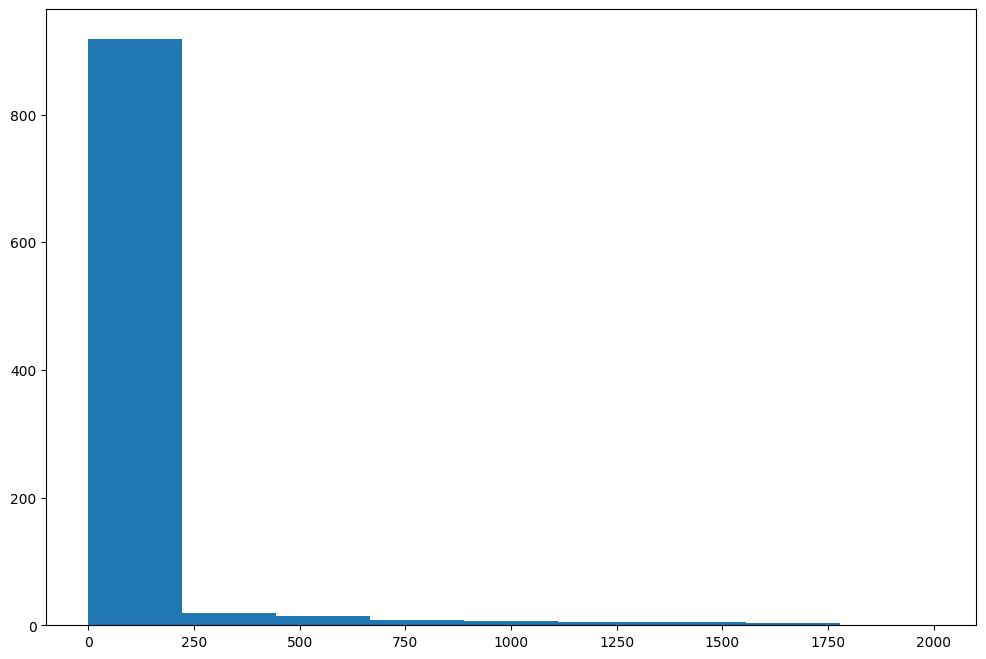

In [63]:
test_df_actual['score'].hist(bins=bin_list,
                             grid=False,
                             figsize=(12,8))

Let's try prototyping the code here: https://towardsdatascience.com/how-to-use-the-reddit-api-in-python-5e05ddfd1e5c

In [24]:
import requests

In [25]:
import json #For retrieving password details

with open('credentials.json') as f:
    data = json.load(f)
    reddit_user = data['reddit_user']
    reddit_pass = data['reddit_password']

In [26]:
#Let's manually get an Oauth token from reddit


auth = requests.auth.HTTPBasicAuth(client_script_id,secret_key)

userdata = {'grant_type': 'password',
        'username': reddit_user,
        'password': reddit_pass}






In [27]:
def request_token():
    #Setup header info for reddit submission page.
    #We need to add a description
    headers = {'User-Agent': 'NBAParser'}
    #Send request for OAuth token
    reddit_response = requests.post('https://www.reddit.com/api/v1/access_token',
                        auth = auth, data=userdata, headers=headers)

    #Convert response to json and grab access_token
    access_token = reddit_response.json()['access_token']

    #Join header dictionary, so not only do you have the name of your "script", you also have the temporary authorization token
    headers = {**headers, **{'Authorization': f"bearer {access_token}"}}

    return headers


Given we have a method of requesting data from reddit, let's write a function to parse a response from reddit. We don't need all the attributes of the response we've requested (E.g. all details of a given post), so we'll premptively filter this.

The total list of keys can be found here: https://www.jcchouinard.com/documentation-on-reddit-apis-json/

In [47]:
def df_from_response(response):
    #Initialize dataframe which we'll append onto existing one
    df = pd.DataFrame()

    #Loop through each post in response and append to df
    for post in response.json()['data']['children']:
        row = pd.DataFrame.from_dict({
            'title': post['data']['title'],
            'upvote_ratio': post['data']['upvote_ratio'],
            'ups': post['data']['ups'],
            'downs': post['data']['downs'],
            'score': post['data']['score'],
            'id': post['data']['id'],
            'kind': post['kind']
        })
        df = pd.concat([df,row], ignore_index=True)

    return df

In [49]:
def df_from_response(response):
    df = pd.json_normalize(response.json()['data']['children'])
    #Filter for specific columns
    df = df[['kind','data.title','data.upvote_ratio','data.score','data.id']]
    #Rename columns
    df.columns = df.columns.str.replace('data.','')

    return df

    

In [142]:
#Setting up df and defining requests.get params as seen in the documentation here: 
#https://www.reddit.com/dev/api/, look under GET [/r/subreddit]/sort for "top" and "controversial"
post_data = pd.DataFrame()
params = {'limit': 100, 't': 'year'} #Inherent limit

In [29]:
headers = request_token()

In [98]:
response = requests.get("https://oauth.reddit.com/r/nba/top",
                    headers= headers,
                    params = params)

To-do list for self: Use PMAW to get a long list of ids from json request, and put them into a list and feed them into requests.get

In [50]:
test_response = requests.get("https://oauth.reddit.com/r/nba/api/info",
                            headers = headers,
                            params = {'id': ids_all[:20]})

In [48]:
df_temp = df_from_response(test_response)

ValueError: If using all scalar values, you must pass an index

In [44]:
df_temp.head()

,kind,title,upvote_ratio,score,id
0,t3,Lonzo inbounds to Zion for the alley oop in tr...,1.0,1,dcejjg


In [33]:
test_response.json()['data']['children']

[{'kind': 't3',
  'data': {'approved_at_utc': None,
   'subreddit': 'nba',
   'selftext': 'The Knicks give up Wilson chandler, Danillo Gallinari, Raymond Felton and a 1st to the jazz \n\nJazz give up\n\nDeron Williams \n\nAl Jefferson \n\nHow much better or worse would the Knicks be with Williams and Jefferson with Amare then just Melo and Amare.',
   'author_fullname': 't2_41kiknzm',
   'saved': False,
   'mod_reason_title': None,
   'gilded': 0,
   'clicked': False,
   'title': 'How much different would the east be if the Knicks traded for Deron Williams instead of Melo?',
   'link_flair_richtext': [],
   'subreddit_name_prefixed': 'r/nba',
   'hidden': False,
   'pwls': 6,
   'link_flair_css_class': None,
   'downs': 0,
   'thumbnail_height': None,
   'top_awarded_type': None,
   'hide_score': False,
   'name': 't3_dcdshn',
   'quarantine': False,
   'link_flair_text_color': 'dark',
   'upvote_ratio': 0.67,
   'author_flair_background_color': '#edeff1',
   'subreddit_type': 'public'

In [ ]:
headers = request_token()

In [158]:
headers = request_token()

for i in range(1):

    response = requests.get("https://oauth.reddit.com/r/nba/",
                    headers=headers,
                    params = {'id': ids_all})

    #Get new dataframe from response from function
    df_temp = df_from_response(response)
    #Take the oldest entry
    last_row = df_temp.iloc[-1]
    #Reconstruct the unique identifier of the oldest post in the series (they're always sorted by score)
    fullname = last_row['kind']+' '+last_row['id']
    #Add this identifier to the "after" key in params, which will cause the subsequetn request to look for the next unique post on the list, below the identifier just mentioned
    params['after'] = fullname

    #Append new data to df
    post_data = pd.concat([post_data, df_temp], ignore_index=True)

    




C:\Users\Albert\AppData\Local\Temp\ipykernel_57524\2135250457.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  df.columns = df.columns.str.replace('data.','')


KeyboardInterrupt: 

In [145]:
post_data.to_json('4000_top_upvoted')

In [151]:
test_df = pd.read_json('4000_top_upvoted')


kind                                                           t3
title           Steph Curry tries to hit the full-court tunnel...
upvote_ratio                                                 0.96
score                                                       20301
id                                                        11p1j2k
Name: 2999, dtype: object

In [153]:
test_df.head()

,kind,title,upvote_ratio,score,id
0,t3,Steve Kerr gives a very heated speech about th...,0.84,88932,ux46gj
1,t3,Charles Barkley: “If you are gay or transgende...,0.83,78215,w0ispx
2,t3,Memphis Grizzlies scorekeeper posting fraudule...,0.89,66842,10nbau4
3,t3,[Highlight] LeBron James is now the scoring Ki...,0.86,58973,10wnucb
4,t3,[Highlight] Chris Paul hits a huge three to cu...,0.93,53542,uql0aw


In [89]:
post_data['title'][0]

'Steve Kerr gives a very heated speech about the Uvalde shooting then storms out'